In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from mpl_toolkits.mplot3d import Axes3D

2.1696090698242188e-05


Text(0.5, 1.0, 'B_y vs X')

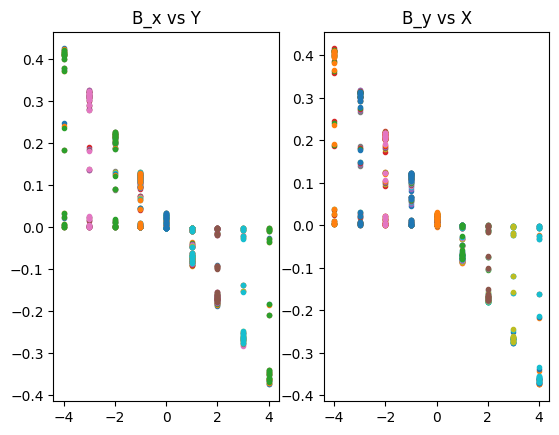

In [10]:


start=time.time()
end = time.time()
print(end-start)

file = 'PMQLLR02_2021_11_15_14.27.txt'
#file = '/Users/sumitnayak/Downloads/Datasets_QPM/QPMLLR01_SNAR_1-1.5-3_data2023_07_17_09.47.txt'

data = np.genfromtxt(file)

x_local= data[0:,5]
y_local= data[0:,6]
z_local= data[0:,7]
B_x = data[0:,8]
B_y = data[0:,9]
B_z = data[0:,10]

step=len(np.unique(z_local)) #----------> number after which Z values repeated / number of diff Z position
num=len(x_local) #-------------->Total Number of data points for a single parameter

#----------------------- Value at different fixed Z values -------------------

x_local_Z = [x_local[j:num:step]  for j in range(step)]
y_local_Z = [y_local[j:num:step]  for j in range(step)]
z_local_Z = [z_local[j:num:step]  for j in range(step)]
Bx_Z = [B_x[j:num:step]  for j in range(step)]
By_Z = [B_y[j:num:step]  for j in range(step)]
Bz_Z = [B_z[j:num:step]  for j in range(step)]

z_local_val= np.unique(z_local)
#print(z_local_val.shape)

plt.subplot(1,2,1)
plt.plot(y_local_Z,Bx_Z,'.')
plt.title('B_x vs Y')
plt.subplot(1,2,2)
plt.plot(x_local_Z,By_Z,'.')
plt.title('B_y vs X')



In [2]:
#--------------- Fitting Bx & By Separately to determine Bx_00, Bx_10,Bx_01,By_00, By_10, By_01-----------

from scipy.optimize import curve_fit

def fit_func(X, B_00, B_10, B_01):
    x,y = X
    return B_00 + B_10*x + B_01*y

param_X,param_Y =[],[]

x = np.array(x_local_Z) # this is of 19x53 order matrix
y = np.array(y_local_Z) # this is of 19x53 order matrix
z1 = np.array(Bx_Z)
z2 = np.array(By_Z)

for i in range(step):
    param1,pocv1=(curve_fit(fit_func, (x[i],y[i]), z1[i]))
    param_X.append(param1)
    param2,pocv2=(curve_fit(fit_func, (x[i],y[i]), z2[i]))
    param_Y.append(param2)
        
param_X=np.array(param_X)
param_Y=np.array(param_Y)
#print(param_Y)
#print(param_X)

Bx_00 = param_X[0:,0]; Bx_10 = param_X[0:,1]; Bx_01 = param_X[0:,2]
By_00 = param_Y[0:,0]; By_10 = param_Y[0:,1]; By_01 = param_Y[0:,2]



In [3]:
# ------------------------------------ Calculating Gx & Alpha_x
from scipy.optimize import fsolve

def alpha_func_x(X,a1,a2):
    G,alpha=X
    return [G * np.sin(alpha) - a1 ,
            G * np.cos(alpha) - a2 ] 
def solve_func(var,a1,a2):
    return fsolve(alpha_func_x,x0=var,args=(a1,a2))

guess = np.array([1,1])
vector_func = np.vectorize(solve_func,excluded=['var'], otypes=[list])
root_x = vector_func(var = guess, a1=(Bx_10),a2 = (Bx_01))
root_x= np.stack(root_x,axis=0)
#print(root_x)

G_x = root_x[0:,0]
alpha_x = (root_x[0:,1])*57.29

# ------------------------------------ Calculating Gy & Alpha_y

def alpha_func_y(Y,b1,b2):
    G,alpha=Y
    return [G * np.cos(alpha) - b1 ,
            -G * np.sin(alpha) - b2 ]
def solve_func(var,b1,b2):
    return fsolve(alpha_func_y,x0=var,args=(b1,b2))

vector_func = np.vectorize(solve_func,excluded=['var'], otypes=[list])
root_y = vector_func(var = guess, b1=(By_10),b2 = (By_01))
root_y= np.stack(root_y,axis=0)
#print(root_y)

G_y = root_y[0:,0]
alpha_y = (root_y[0:,1])*57.29

# ------------------------------------ Calculating Magnetic Centre (Xc & Yc)

magcentre_y = -(Bx_00/Bx_01) 
magcentre_x = -(By_00/By_10)



In [71]:
def generateB(z_val, alphaX, alphaY, GX, GY, magcentreX, magcentreY):

    #generate x,y inside bore radius, this is for QPMLLR2, so radius is 9 mm
    xArray = []
    yArray = []
    for i in range(9):
        xArray.append(-4 + i)
        yArray.append(-4 + i)
        
    
    Bx = []
    By = []

    print(alpha_x)
    
    for i in range(len(z_val)):
        x = np.linspace(-4, 4, 9)
        y = np.linspace(-4, 4, 9)
        X, Y = np.meshgrid(x, y)
    
        # Define the functions Bx and By
        Bx = math.sin(np.radians(alpha_x[i]) ) * GX[i] * (X - magcentre_x[i]) - math.cos(np.radians(alpha_y[i]) )* GY[i] * (Y - magcentre_y[i])
        By = math.cos(np.radians(alpha_x[i]) )* GX[i] * (X - magcentre_x[i]) - math.cos(np.radians(alpha_y[i]) )* GY[i] * (Y - magcentre_y[i])
    
        # Plot for Bx
        plt.figure()
        plt.pcolormesh(X, Y, Bx, shading='auto', cmap='coolwarm')  # Create a 2D heatmap
        plt.colorbar(label='Bx Value (Z-axis)')  # Add a colorbar for the Z values
        plt.xlabel('X Axis')
        plt.ylabel('Y Axis')
        plt.title(f'COLZ-like plot for Bx (z_val[{i}])')
        plt.show()
    
        # Plot for By
        plt.figure()
        plt.pcolormesh(X, Y, By, shading='auto', cmap='coolwarm')  # Create a 2D heatmap
        plt.colorbar(label='By Value (Z-axis)')  # Add a colorbar for the Z values
        plt.xlabel('X Axis')
        plt.ylabel('Y Axis')
        plt.title(f'COLZ-like plot for By (z_val[{i}])')
        plt.show()
    '''
        for x in xArray:
            for y in yArray:
                Bx.append(math.sin(alpha_x[i])*GX[i]*(x - magcentre_x[i]) + math.cos(alpha_y[i])*GY[i]*(y - magcentre_y[i]))
                By.append(math.cos(alpha_x[i])*GX[i]*(x - magcentre_x[i]) + math.sin(alpha_y[i])*GY[i]*(y - magcentre_y[i]))

                
        
    '''


[-3.6151783  -3.08609551 -1.69407563  1.48881201 -0.17386614 -0.33918406
 -0.53247459 -0.47060306 -0.65882215 -1.66728118 -1.46114476 -0.57148519
 -1.33747743 -0.72312879 -0.14086006  0.02247247  0.25688254  0.51676174
  1.16093705]


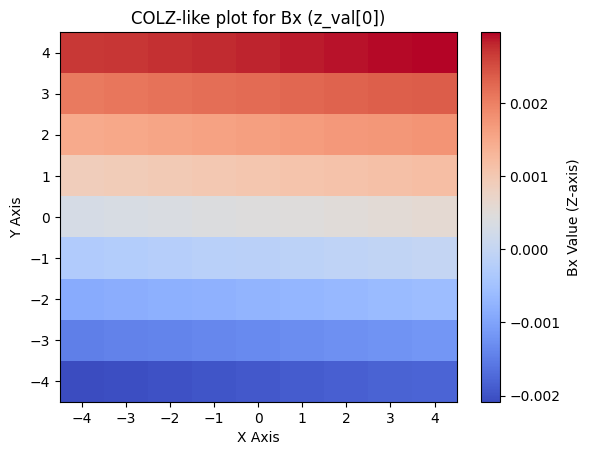

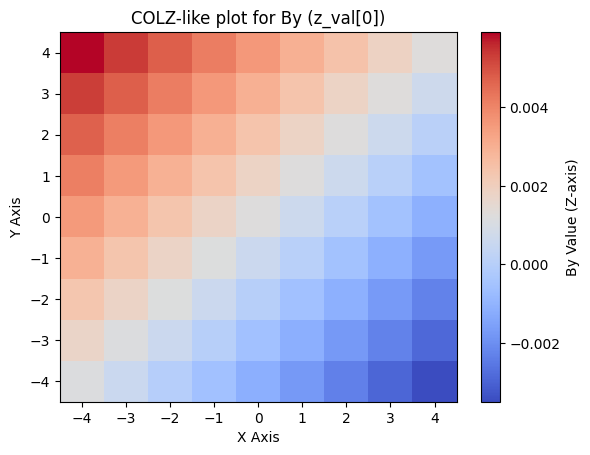

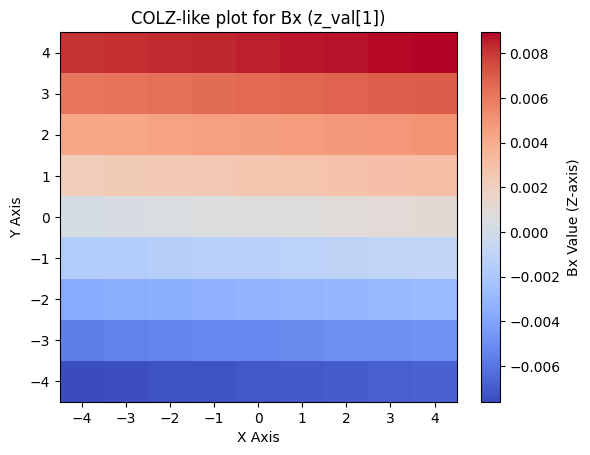

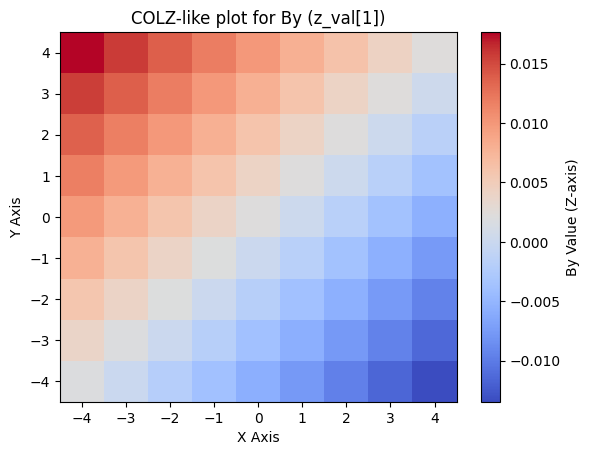

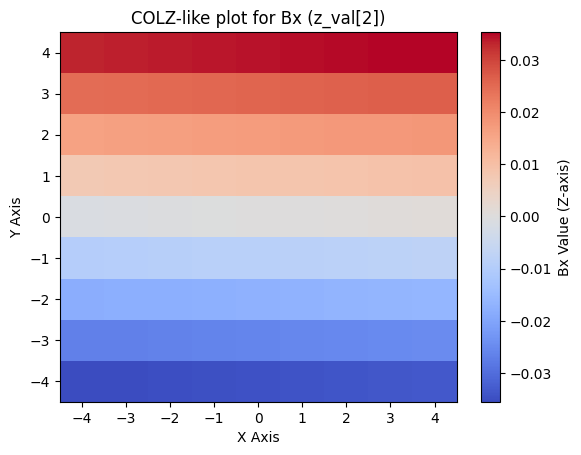

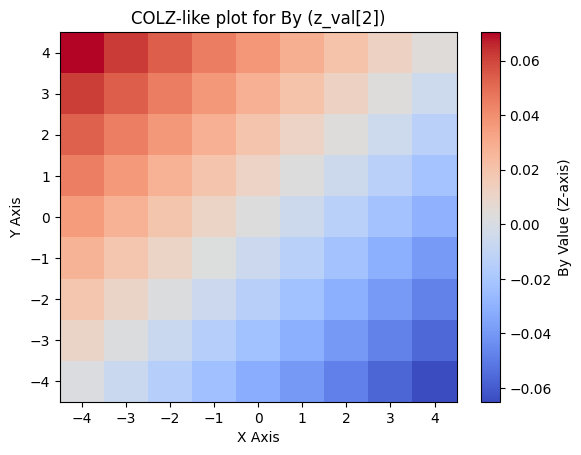

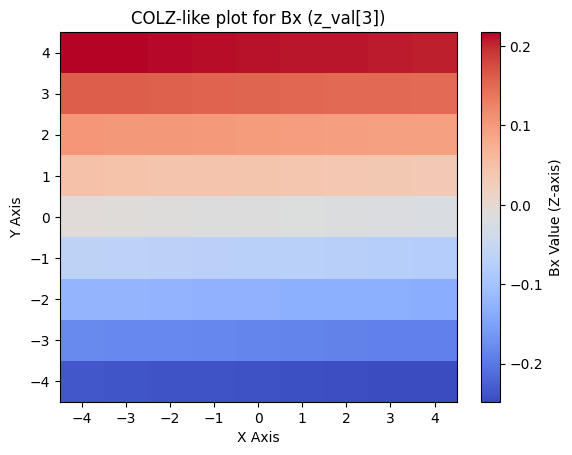

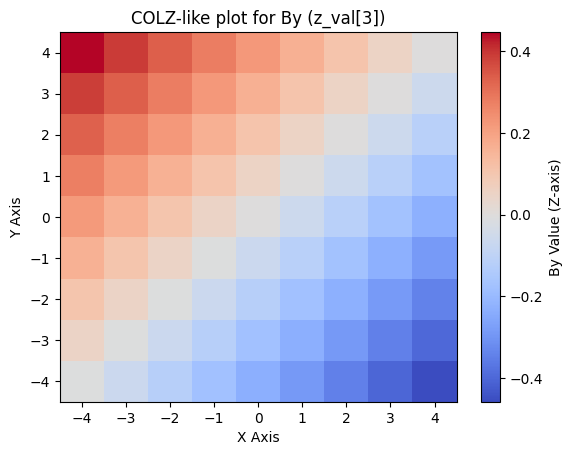

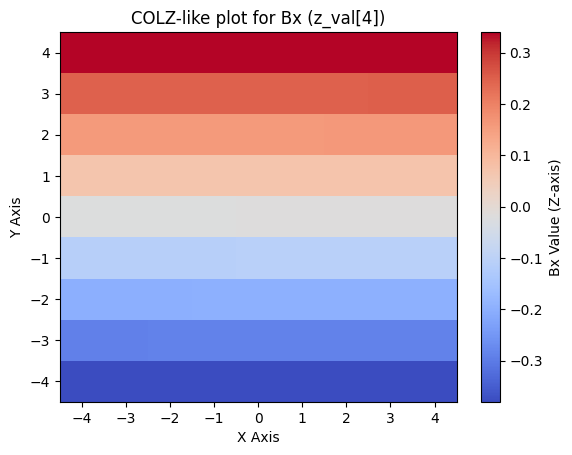

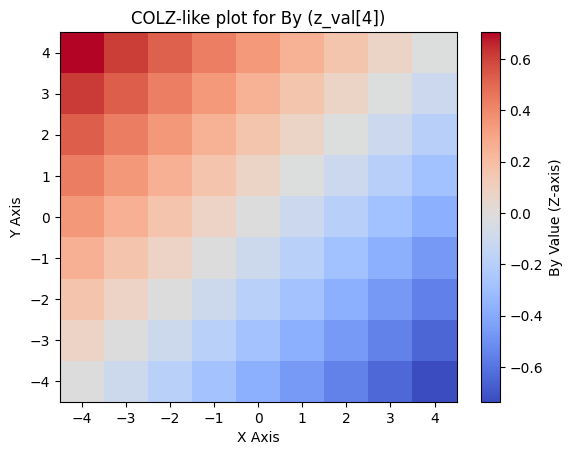

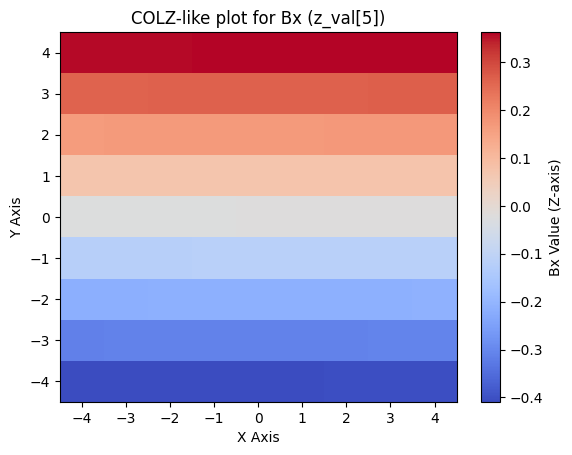

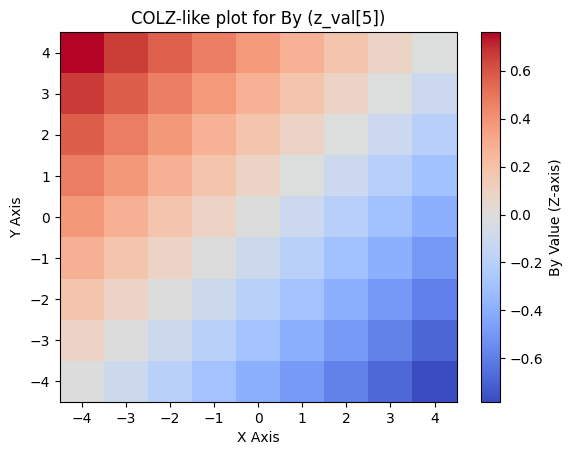

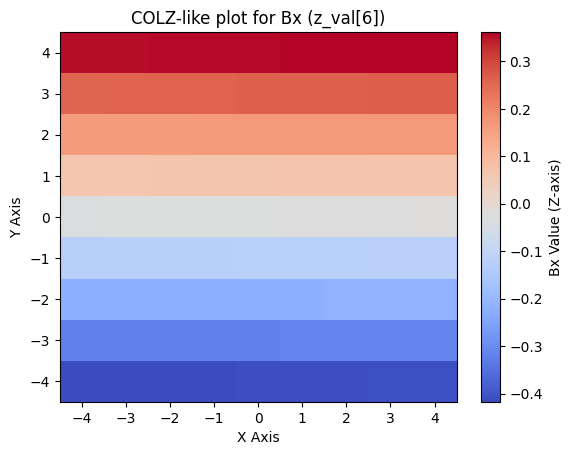

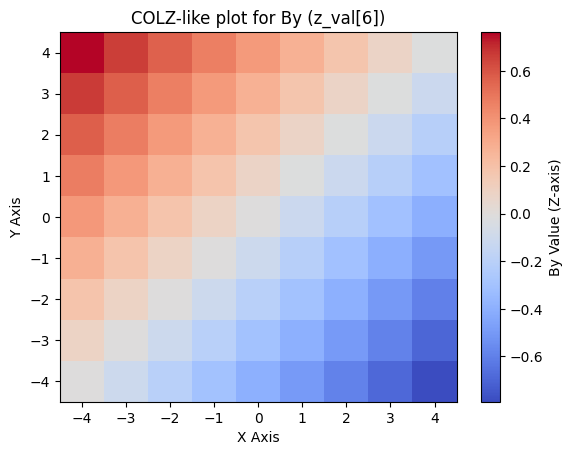

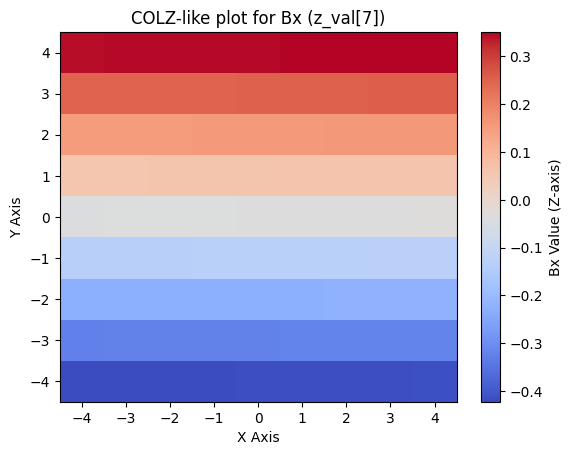

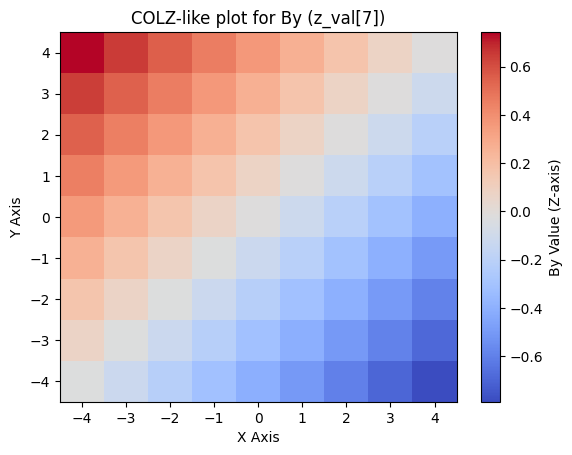

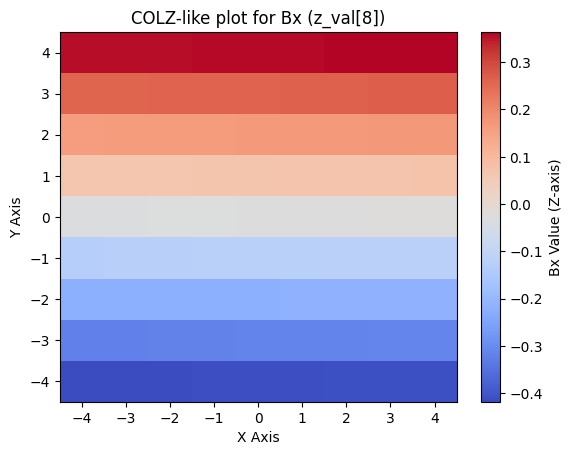

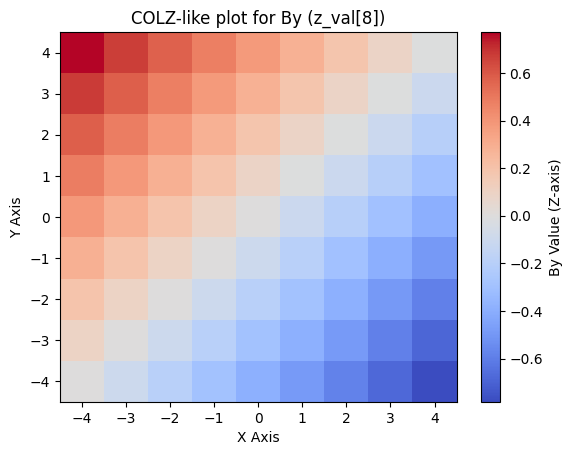

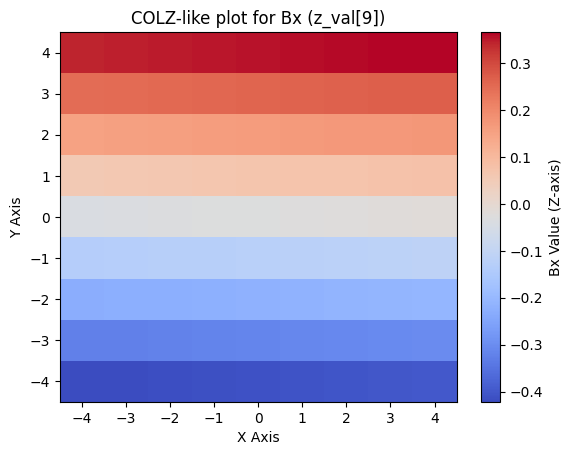

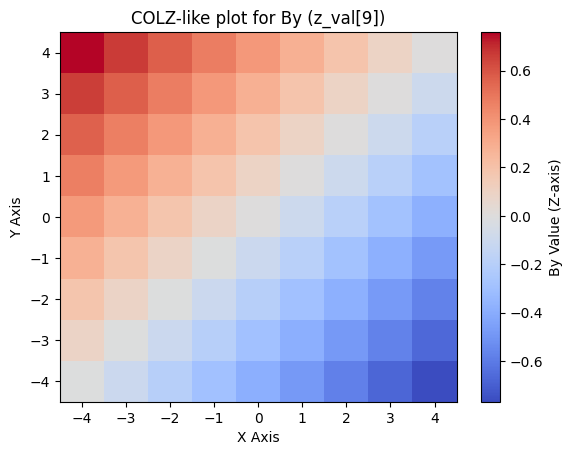

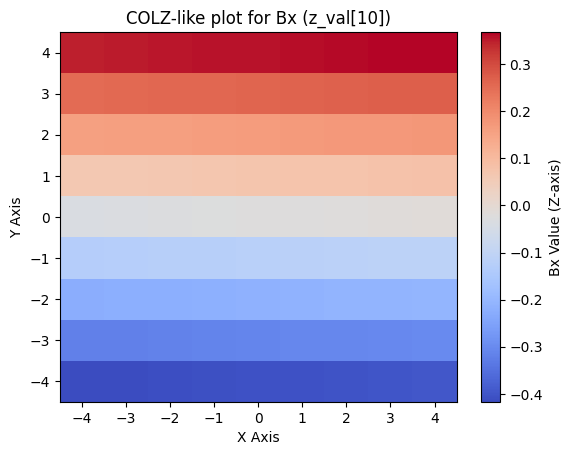

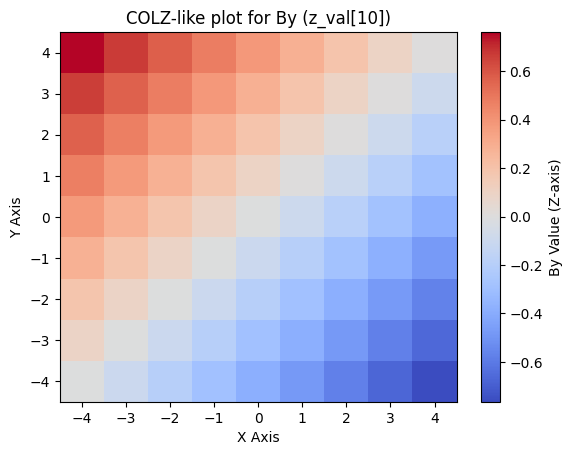

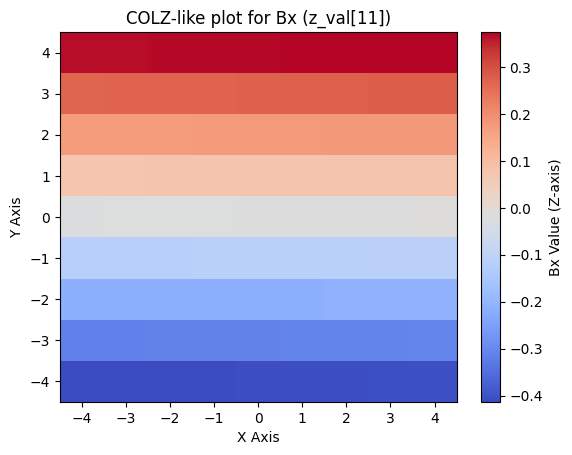

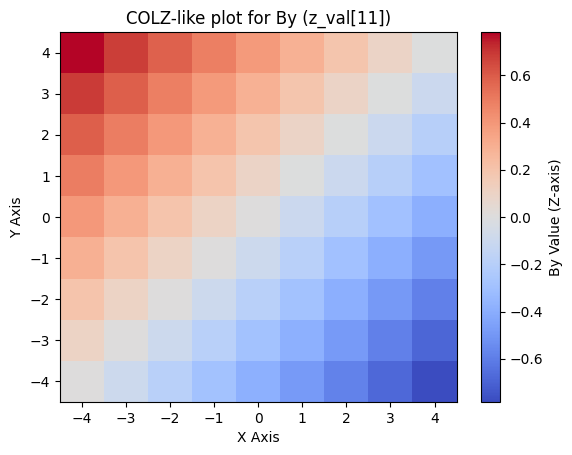

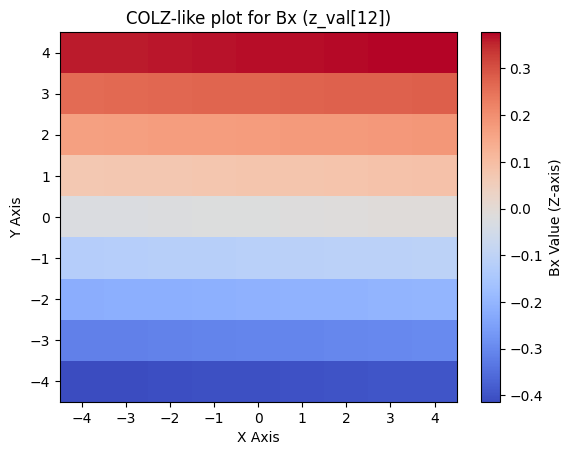

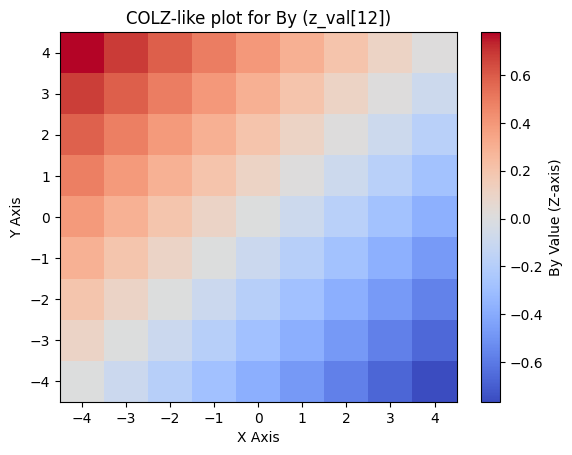

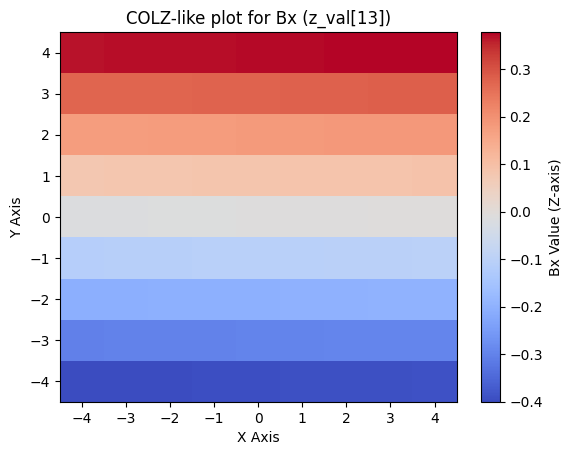

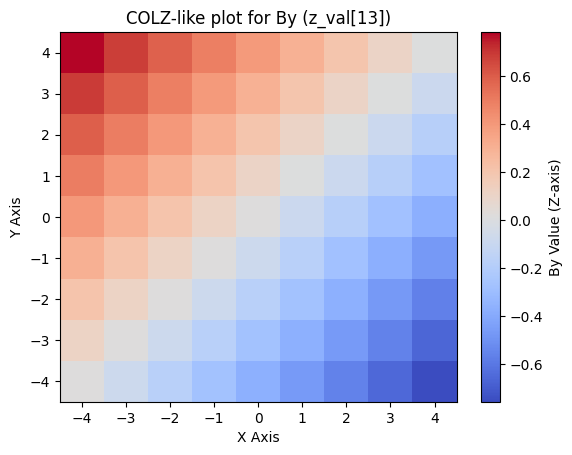

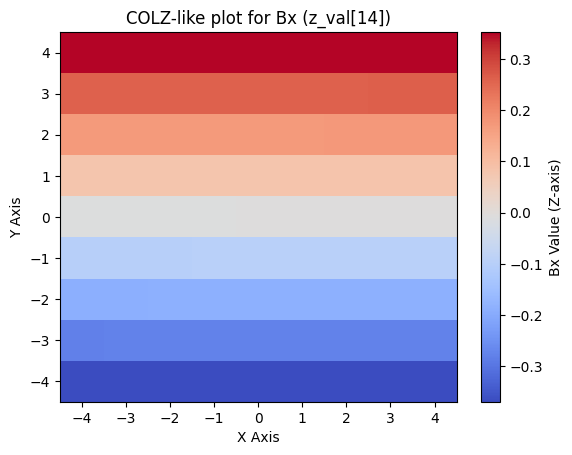

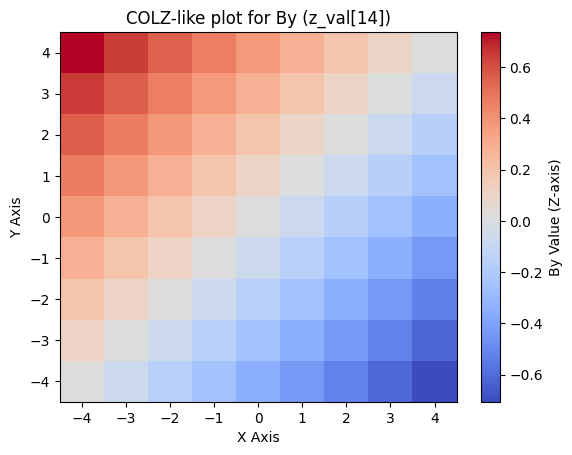

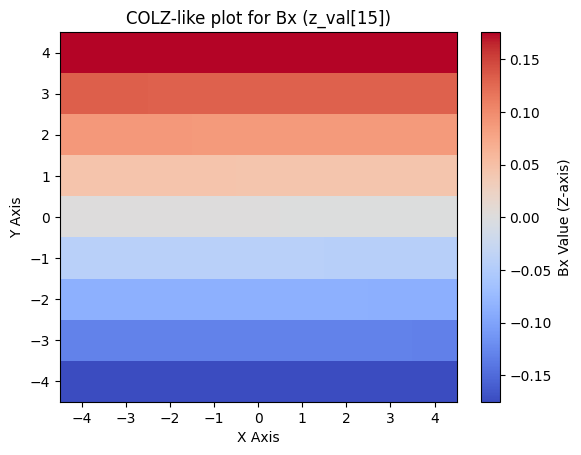

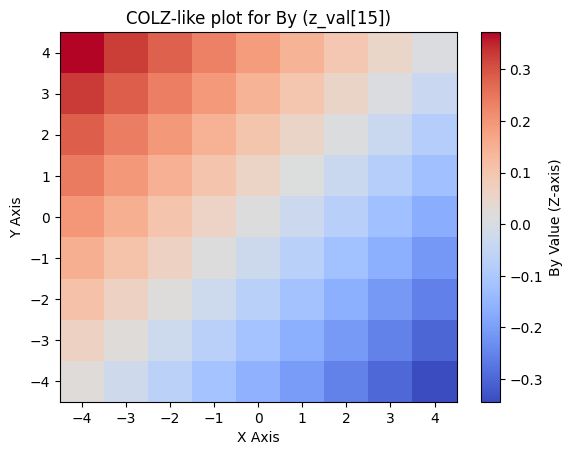

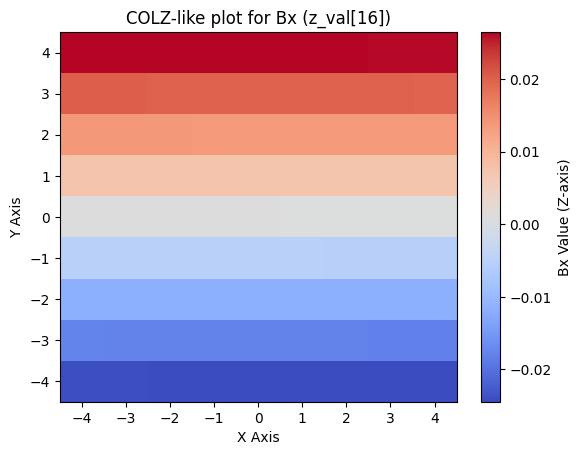

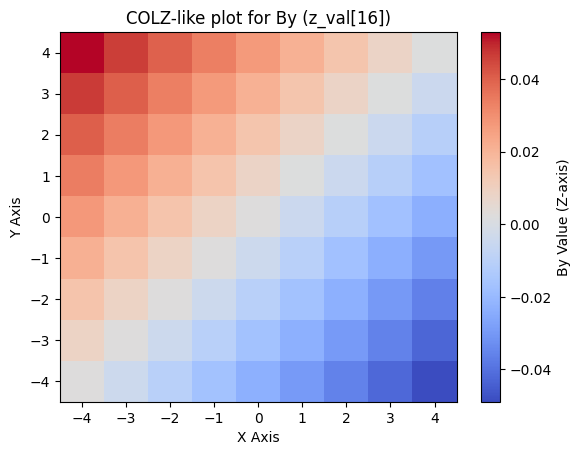

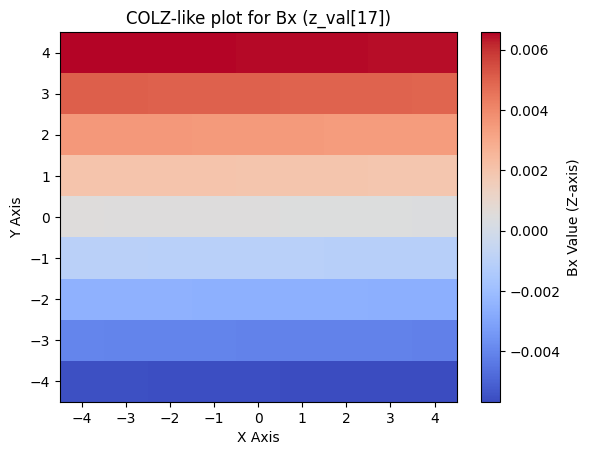

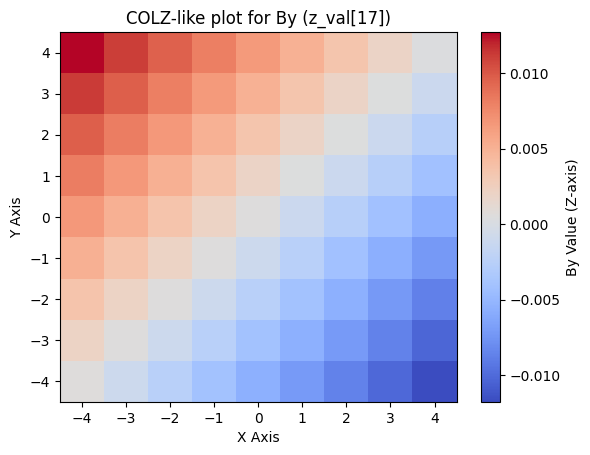

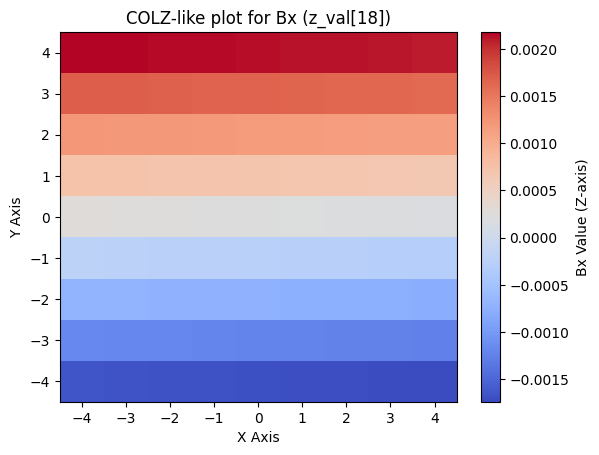

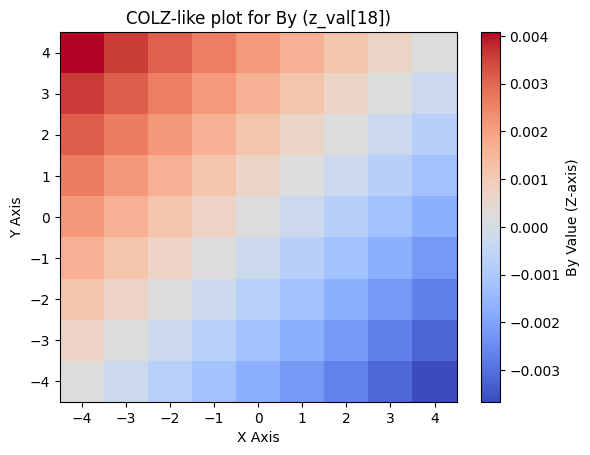

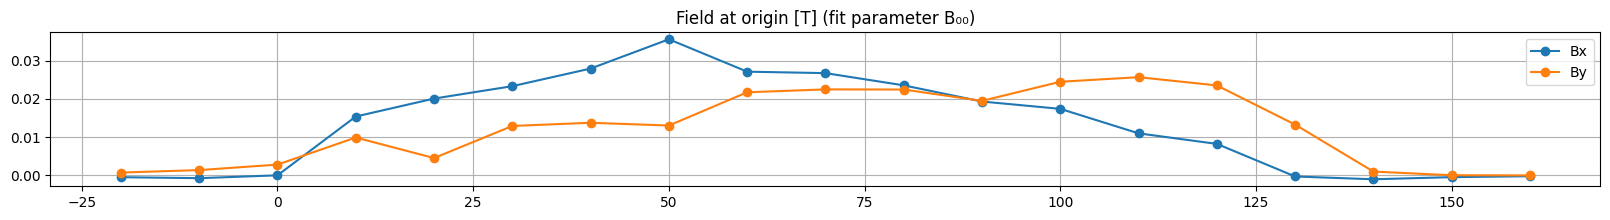

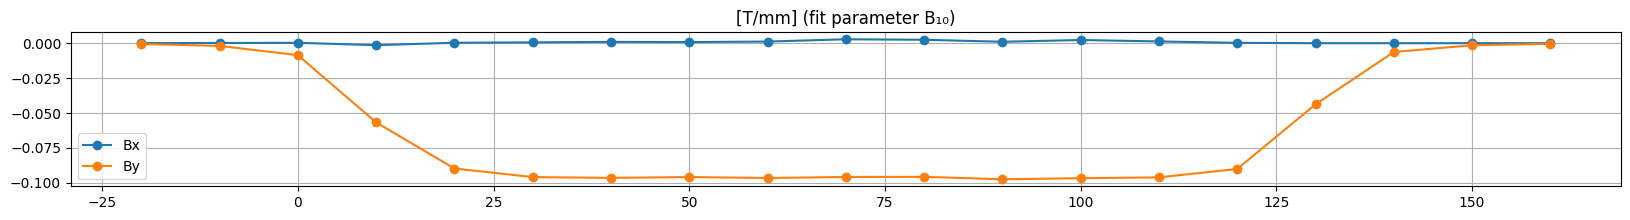

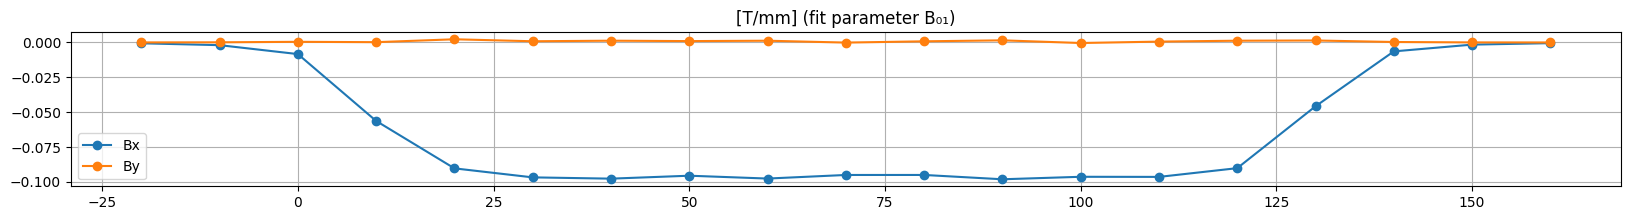

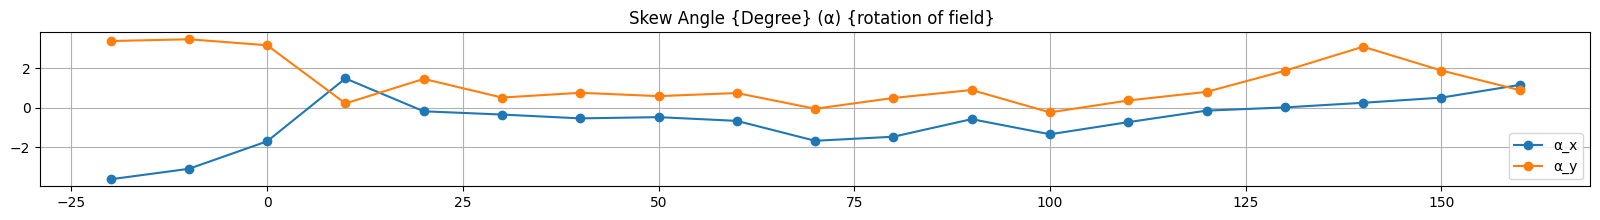

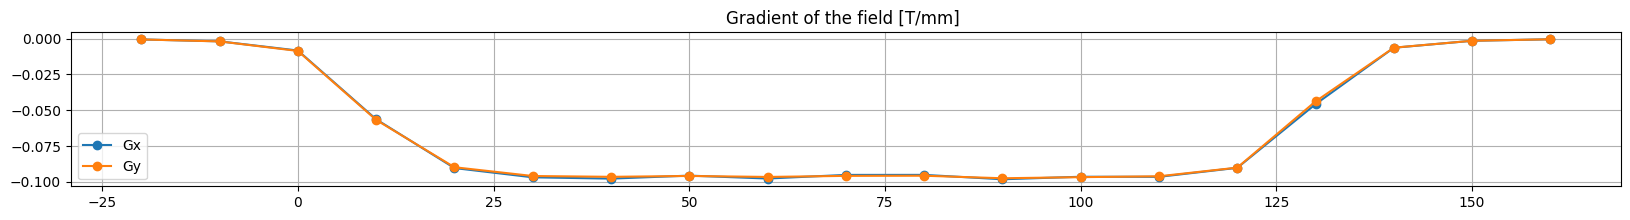

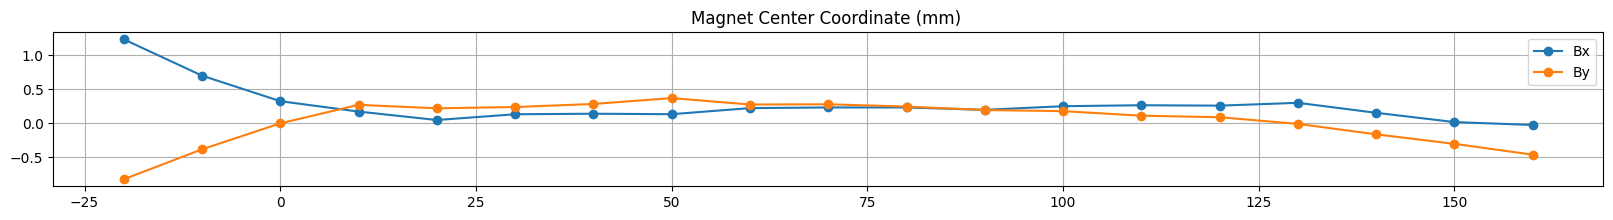

In [72]:
generatedData = generateB(z_local_val, alpha_x, alpha_y, G_x, G_y, magcentre_x, magcentre_y)



plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_00,'o-',label='Bx')
plt.plot(z_local_val,By_00,'o-',label='By')
#plt.ylim(-0.05,+0.05)
plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_10,'o-',label='Bx')
plt.plot(z_local_val,By_10,'o-',label='By')
#plt.ylim(-0.1,0.01)
plt.title('[T/mm] (fit parameter B\u2081\u2080)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,Bx_01,'o-',label='Bx')
plt.plot(z_local_val,By_01,'o-',label='By')
#plt.ylim(-0.1,0.01)
plt.title('[T/mm] (fit parameter B\u2080\u2081)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,alpha_x,'o-',label='\u03B1_x')
plt.plot(z_local_val,alpha_y,'o-',label='\u03B1_y')
#plt.ylim(-.1,.1)
plt.title('Skew Angle {Degree} (\u03B1) {rotation of field} ')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,G_x,'o-',label='Gx')
plt.plot(z_local_val,G_y,'o-',label='Gy')
#plt.ylim(-.11,.05)
plt.title('Gradient of the field [T/mm] ')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=(20,2))   
plt.plot(z_local_val,magcentre_x,'o-',label='Bx')
plt.plot(z_local_val,magcentre_y,'o-',label='By')
#plt.ylim(-.5,.5)
plt.title('Magnet Center Coordinate (mm) ')
plt.legend(loc='best')
plt.grid()
plt.show()


In [14]:
from scipy.optimize import least_squares

def simult_fit(X,z1,w1,x1,y1):
    Bx_00, Bx_10, Bx_01,By_00, By_10, By_01 = X
    return np.array([ z1-(Bx_00 + Bx_10*x1 + Bx_01*y1) ,
                     w1-(By_00 + By_10*x1 + By_01*y1) ])
def solve_func(var,z1,w1,x1,y1):
    cc = least_squares(simult_fit,var,args=(z1,w1,x1,y1))
    return cc.x

guess_initial=np.array([0.02,0,-0.1,0.02,-0.1,0]) #----------->assumed from graph plotted earlier
vector_func = np.vectorize(solve_func,excluded=['var'], otypes=[list])
dd = vector_func(var = guess_initial, z1 = Bx_Z,w1 = np.array(By_Z),x1 = np.array(x_local_Z),y1 = np.array(y_local_Z))
dd= np.stack(dd,axis=0)

print(dd.shape)


(19, 53)


In [7]:
######### Finding the Centre of the Circle #########

import sympy as sym
x,y,r = sym.symbols('x,y,r')
x1 = sym.Symbol('x1')
x2 = sym.Symbol('x2')
x3 = sym.Symbol('x3')
y1 = sym.Symbol('y1')
y2 = sym.Symbol('y2')
y3 = sym.Symbol('y3')
eq1 = sym.Eq((x-x1)**2 + (y-y1)**2,r**2)
eq2 = sym.Eq((x-x2)**2 + (y-y2)**2,r**2)
eq3 = sym.Eq((x-x3)**2 + (y-y3)**2,r**2)

result = sym.solve([eq1,eq2,eq3],(x,y,r))
print((result))


[((x1**2*y2 - x1**2*y3 - x2**2*y1 + x2**2*y3 + x3**2*y1 - x3**2*y2 + y1**2*y2 - y1**2*y3 - y1*y2**2 + y1*y3**2 + y2**2*y3 - y2*y3**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -(x1**2*x2 - x1**2*x3 - x1*x2**2 + x1*x3**2 - x1*y2**2 + x1*y3**2 + x2**2*x3 - x2*x3**2 + x2*y1**2 - x2*y3**2 - x3*y1**2 + x3*y2**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -sqrt((x1**2 - 2*x1*x2 + x2**2 + y1**2 - 2*y1*y2 + y2**2)*(x1**2 - 2*x1*x3 + x3**2 + y1**2 - 2*y1*y3 + y3**2)*(x2**2 - 2*x2*x3 + x3**2 + y2**2 - 2*y2*y3 + y3**2))/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2))), ((x1**2*y2 - x1**2*y3 - x2**2*y1 + x2**2*y3 + x3**2*y1 - x3**2*y2 + y1**2*y2 - y1**2*y3 - y1*y2**2 + y1*y3**2 + y2**2*y3 - y2*y3**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), -(x1**2*x2 - x1**2*x3 - x1*x2**2 + x1*x3**2 - x1*y2**2 + x1*y3**2 + x2**2*x3 - x2*x3**2 + x2*y1**2 - x2*y3**2 - x3*y1**2 + x3*y2**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)), sqrt((x1**2 - 2*x1*x2 + x2**2 + y1**2 

In [8]:
import sympy as sym
import numpy as np
x,y,r = sym.symbols('x,y,r')

filename_1 = '/Users/sumitnayak/Downloads/Datasets_QPM/Centre of Bore/PQMLLR03_exitplane_2023.07.03.txt'

data_1 = np.genfromtxt(filename_1) 

x1 = data_1[0:,0] ; y1 = data_1[0:,1]
x2 = data_1[0:,2] ; y2 = data_1[0:,3]
x3 = data_1[0:,4] ; y3 = data_1[0:,5]

for i in range(2):
    eq1 = sym.Eq((x-x1[i])**2 + (y-y1[i])**2,r**2)
    eq2 = sym.Eq((x-x2[i])**2 + (y-y2[i])**2,r**2)
    eq3 = sym.Eq((x-x3[i])**2 + (y-y3[i])**2,r**2)

    result = sym.solve([eq1,eq2,eq3],(x,y,r))
    print(result)


FileNotFoundError: /Users/sumitnayak/Downloads/Datasets_QPM/Centre of Bore/PQMLLR03_exitplane_2023.07.03.txt not found.

In [ ]:
import sympy as sym
import numpy as np
x,y,r = sym.symbols('x,y,r')

x1 = 1622 ; y1 = 525
x2 = 303 ; y2 = 332
x3 = 1076 ; y3 = 19


eq1 = sym.Eq((x-x1)**2 + (y-y1)**2,r**2)
eq2 = sym.Eq((x-x2)**2 + (y-y2)**2,r**2)
eq3 = sym.Eq((x-x3)**2 + (y-y3)**2,r**2)

result = sym.solve([eq1,eq2,eq3],(x,y,r))
print(result)
